# **В качестве датасета для обучения модели был выбран 20 newsgroups**

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on
# Загрузка линтера

In [2]:
from sklearn.datasets import fetch_20newsgroups


# Фиксирование случайнонго состояния
SEED = 42
# Загрузка датасета из sklearn
newsgroups = fetch_20newsgroups(subset='all')

## **Осмотр датасета**

In [3]:
import pandas as pd

# Конфертация в pandas Dataframe
data = pd.DataFrame(columns=["Text", "Target"])
data["Text"] = newsgroups.data
data["Target"] = newsgroups.target

# Имена для конвертации индексов
target_names = newsgroups.target_names

# Удаление дубликата датасета из памяти
del newsgroups

print(f"Размер датасета: {data['Text'].size}")

# Кол-во классов
CLS_COUNT = len(data["Target"].unique())

data.head()

Размер датасета: 18846


,Text,Target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


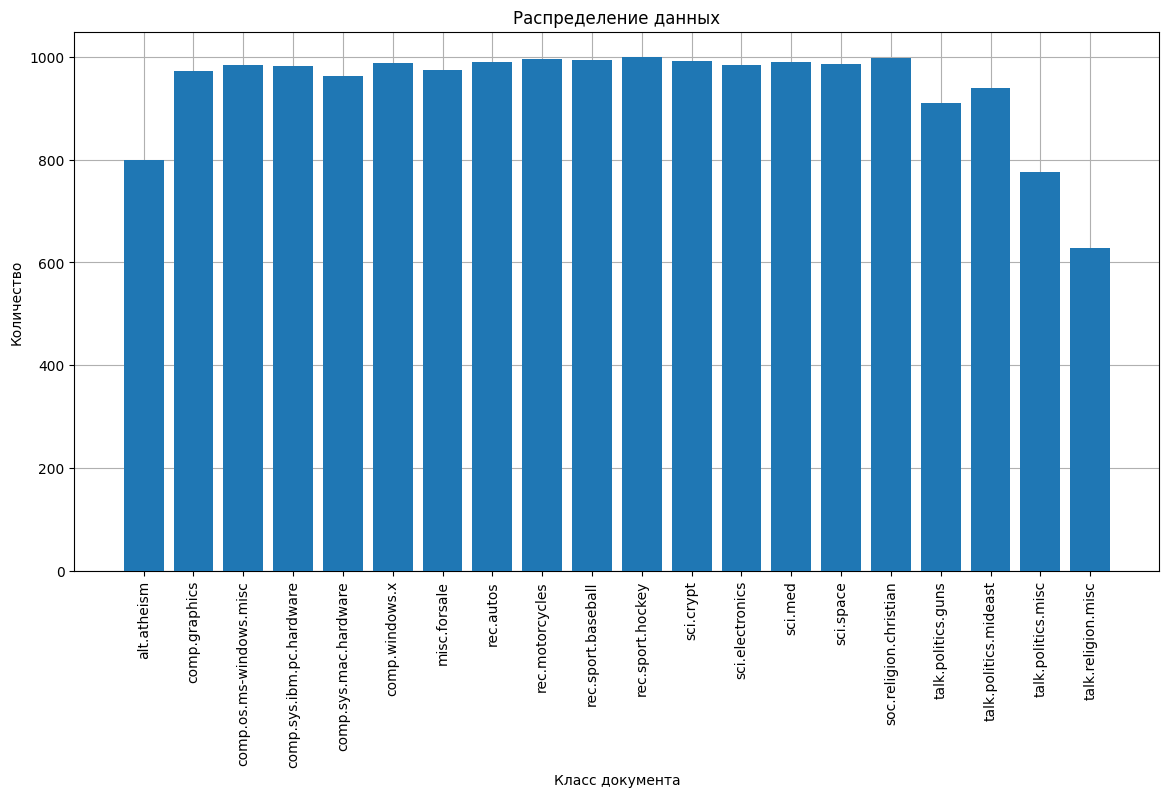

In [4]:
import matplotlib.pyplot as plt


# Построение графика распределения данных
# data - dataframe с данными
# дпредполагается что класс документа содержится в колонке Target
def showDistribution(data: pd.DataFrame, title: str) -> None:
    # Кол-во данных для каждого класса документов
    value_counts = data["Target"].value_counts()
    # Упорядочивание значений по классам
    value_counts = [value_counts[cls] for cls in range(0, CLS_COUNT)]

    plt.figure(figsize=(14, 7))
    plt.grid(zorder=0)

    plt.bar(target_names, value_counts, zorder=3)

    plt.title(title)
    plt.xlabel("Класс документа")
    plt.ylabel("Количество")

    plt.xticks(rotation=90)

    plt.show()


showDistribution(data, "Распределение данных")

---

**На тему религии документов в половину меньше от большинства остальных, но в целом датасет +- сбаласированный, доп операции для балансироваки проводится не будут**

---

**Семпл данных**

In [85]:
target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [84]:
# Позволить pandas отображать длинные строки
pd.options.display.max_colwidth = 1000

data["Text"].sample(2, random_state=SEED)

12869    In article 1993Apr3 . 221837 . 2324news duc auburn edu bixledneng auburn edu In article 16193cbnews cb att com , lvccbnews cb att com Larry Cipriani No , you haven not read it very closely . It says you may answer No if your civil rights have been restored that can be done either by the feds or a a state . I think the feds stopped doing this for those convicted of violent felonies . At least a dozen states still restore a felons civil rights , some immediately upon release , some after a waiting period . I will post a list of the states later . A quick question , then Larry , If a person is civil rights have been restored , then are they still considered a felon ? Good question I don not know what the law considers them . IMO , if rights have been restored , then it makes sense to me that the record of the felony , and everything else has been purged , and the person in question is no longer a felon . I believe this is what happens in some states . Larry Cipriani l v cipriania

---

**В каждом тексте присутвуют поля с доп данными о каждом тесксте (From, Subject и Lines, Organization и т.д.), так же данные засорены различными служебными симвлолами.**

---

### **Удаление доп данных в начале текста** 

In [6]:
import re


# Функция принимает:
# список полей fieldTitles - список ключевых слов с которых начинаются поля
# sep - сепаратор, символ окончания поля,
# в данном случае каждое поле в датасете заканчивается символом новой строки \n
# text - сам текст одного вхождения данных
def removeFields(text: str) -> str:

    # Выделение поля - набора символов алфоовита и цифр
    # а так же служебных символов . -
    regex = "[A-Za-z.-0-9]+:.*\n"
    # Удаление полдстроки/замена на пустую подстроку
    text = re.sub(regex, '', text)

    return text

In [7]:
# Выбор документа для примера
text = data["Text"].iloc[1]

fieldlessText = removeFields(text)

print(f"До: \n\n{text} \n\nПосле: \n\n{fieldlessText}")

До: 

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   
 

После: 


  My brother is in

### **Очистака от служебных символов = - + >> и т.д.**

In [8]:
# Функция принимает:
# text - текст одного вхождения данных
def specialCharacterCleaner(text: str) -> str:

    startText = text
    # Удаление апострофов используется для слов тиках как:
    # can't wouldn't и т.д.
    text = re.sub("'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("'s", " is", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'m", " am", text)

    # Выделение переходов на новую строку и дубликатов пробелов
    regex = "[\r\n\t\\s]+"
    # Замена выделенных подстрок на единый символ разделения ' '
    text = re.sub(regex, ' ', text)

    # Выделение пробела в начале строки
    regex = "^\\s"
    # замена на пустую строку
    text = re.sub(regex, '', text)

    # Некоторые данные пустые или же крайне малы
    # Например:
    #
    # From: xchen@vax2.concordia.ca (CHEN, XIA)
    # Subject: how
    # News-Software: VAX/VMS VNEWS 1.41
    # Nntp-Posting-Host: vax2.concordia.ca
    # Organization: Concordia University
    # Lines: 0
    #
    if len(text) < 5:
        return None

    # Удаление спецсимволов внутри слов
    resText = text[0]  # Отфильтрованная строка
    for i in range(1, len(text)):

        match text[i]:

            # Удаление спецсимволов являющихся частью слова
            # (считаю что если точка не в конце слова,
            # то является его частью например -
            # .net или shelley.u.washington.edu)
            case '.' | '-':

                nextIsLetter = False
                # Является ли текущий символ не последним в строке
                if i < len(text) - 1:
                    # Является ли след символ частью слова
                    nextIsLetter = text[i+1].isalpha()

                # Находится ли точка внутри слова
                if nextIsLetter:
                    # замена точки на разделение слов
                    resText += ' '
                else:
                    resText += text[i]

            # Любые иные символы записываются без изменений
            case _:
                resText += text[i]

    # Присвоение нового тескта
    text = resText
    # Удаление дубликата
    del resText

    # Выделение спецсимволов не являющихся символами пунктуации
    regex = "[^\\w 0-9.!?,]"
    # Замена на пустую строку
    text = re.sub(regex, '', text)

    # Замена двух и более символов пунктуации одним
    # ... -> .
    regex = "[.]{2,}"  # Выделение подстрок из 2 и более точек
    text = re.sub(regex, '.', text)  # Замена на одну точку
    # !!! -> !
    regex = "[!]{2,}"
    text = re.sub(regex, '!', text)
    # ??? -> ?
    regex = "[?]{2,}"
    text = re.sub(regex, '?', text)
    # ,,, -> ,
    regex = "[,]{2,}"
    text = re.sub(regex, ',', text)

    # Обрамление символов пунктуации пробелами
    # для послдеющего выделения их как отдельных слов - токенов
    text = re.sub('[.]', " . ", text)
    text = re.sub('[!]', " ! ", text)
    text = re.sub('[?]', " ? ", text)
    text = re.sub('[,]', " , ", text)

    # Замена дублиактов пробелов

    # Выделение подстрок состоящих из двух и более пробелов
    regex = " {2,}"
    # Замена выделенных подстрок на единичные пробелы
    text = re.sub(regex, ' ', text)
    return text

In [9]:
cleanText = specialCharacterCleaner(fieldlessText)

print(f"До: \n\n{fieldlessText} \n\nПосле: \n\n{cleanText}")

До: 


  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas 
  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   
 

После: 

My brother is in the market for a high performance video card that supports VESA local bus with 12MB RAM . Does anyone have suggestionsideas Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other high performance VLB card Please post or email . Thank you ! Matt Matthew B . Lawson mblawsonessex ecn uoknor edu No

### **Проверка орфоргафии**

In [10]:
from spellchecker import SpellChecker


# Примнимает лист слов words
# Лист слов с коррекциями если нужны
def spellCheck(words: list[str]) -> list[str]:

    # Загрузка спеллчекера
    spell = SpellChecker(language="en")

    # Корректировка слов
    # если слово распознано как несуществующее возвращается None
    correctedWords = [spell.correction(word) for word in words]
    # None исключается из текста
    correctedWords = [word for word in correctedWords if word is not None]
    return correctedWords

In [11]:
# Пример работы

testWords = ["Heloo", "neighbar", "abdfdc", "bye", "?"]

spellCheck(testWords)

['hello', 'neighbor', 'bye', '?']

### **Обработка данных**

---

**Построение пайплайна**

---

In [12]:
# Функция разбиения текста слова/токены
def splitText(text: str) -> list:
    return text.split()


splitText(cleanText)[:10]

['My',
 'brother',
 'is',
 'in',
 'the',
 'market',
 'for',
 'a',
 'high',
 'performance']

In [13]:
from functools import reduce
from collections.abc import Callable


# Композиция нескольких функций
# fs - функции для составления композиции/пайплайна
def compose(*fs: tuple[Callable, ...]) -> Callable:

    # Композиция двух функций f, g
    # Возращаемый тип неизвестен, зависит от последней функции в композиции
    def compose2(f: Callable, g: Callable):
        return lambda x: f(g(x))

    # Построение самой композиции при помощи reduce
    composite_fn = reduce(compose2, fs, lambda x: x)
    return composite_fn


# Построение пайплайна для предобработки данных датасета.
# спеллчекинг будет использоваться только для pdf ввода
# из-за низкой производительности
preprocessDataset = compose(specialCharacterCleaner,
                            removeFields)

In [14]:
prepd = preprocessDataset(text)

print(f"До: \n\n{text} \n\nПосле: \n\n{prepd}")

До: 

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   
 

После: 

My brother is in th

In [15]:
from tqdm import tqdm


tqdm.pandas()
# Применение пренпроцессинга к данным
data["Text"] = data["Text"].progress_apply(preprocessDataset)

100%|███████████████████████████████████████████████████████████████████████████| 18846/18846 [00:09<00:00, 2056.22it/s]


In [16]:
data.size

37692

In [17]:
# Удаление пустых данных
data = data.dropna()
data.size

37620

### **Разбиение на выборки и их проверка на сбалансированность**

In [18]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data, test_size=0.2, random_state=SEED)

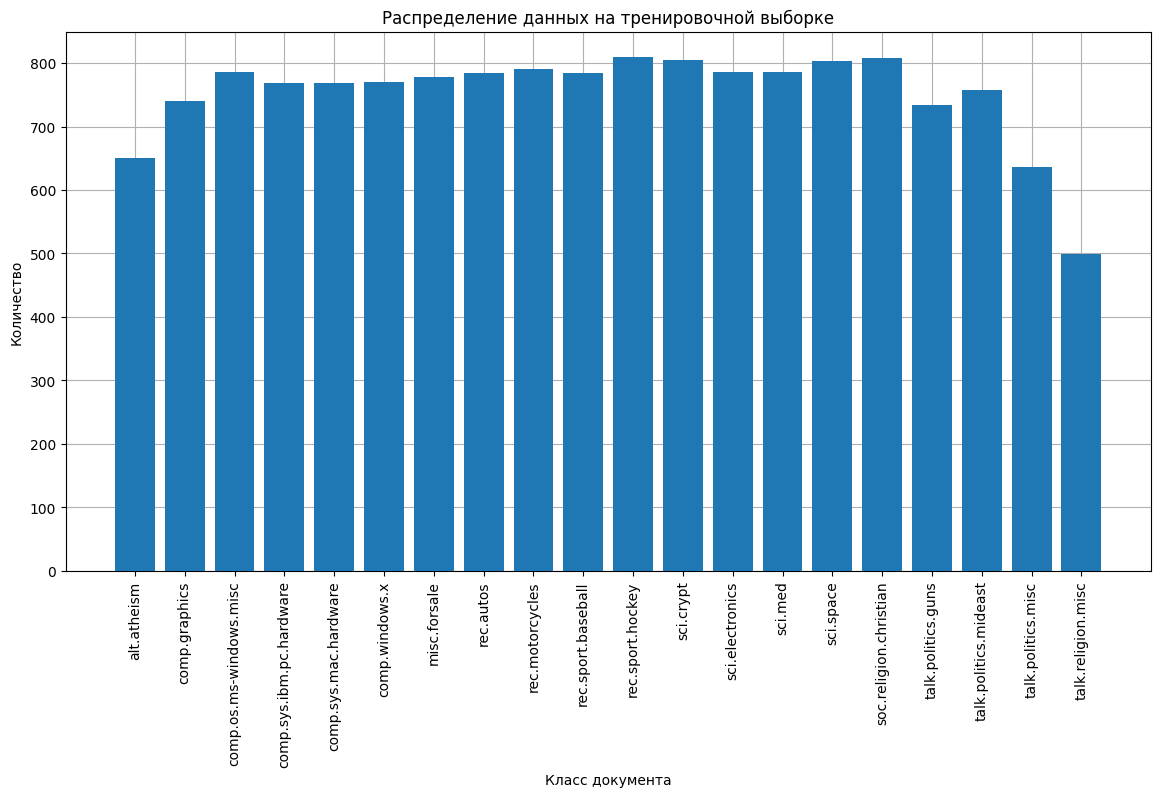

In [19]:
showDistribution(train, "Распределение данных на тренировочной выборке")

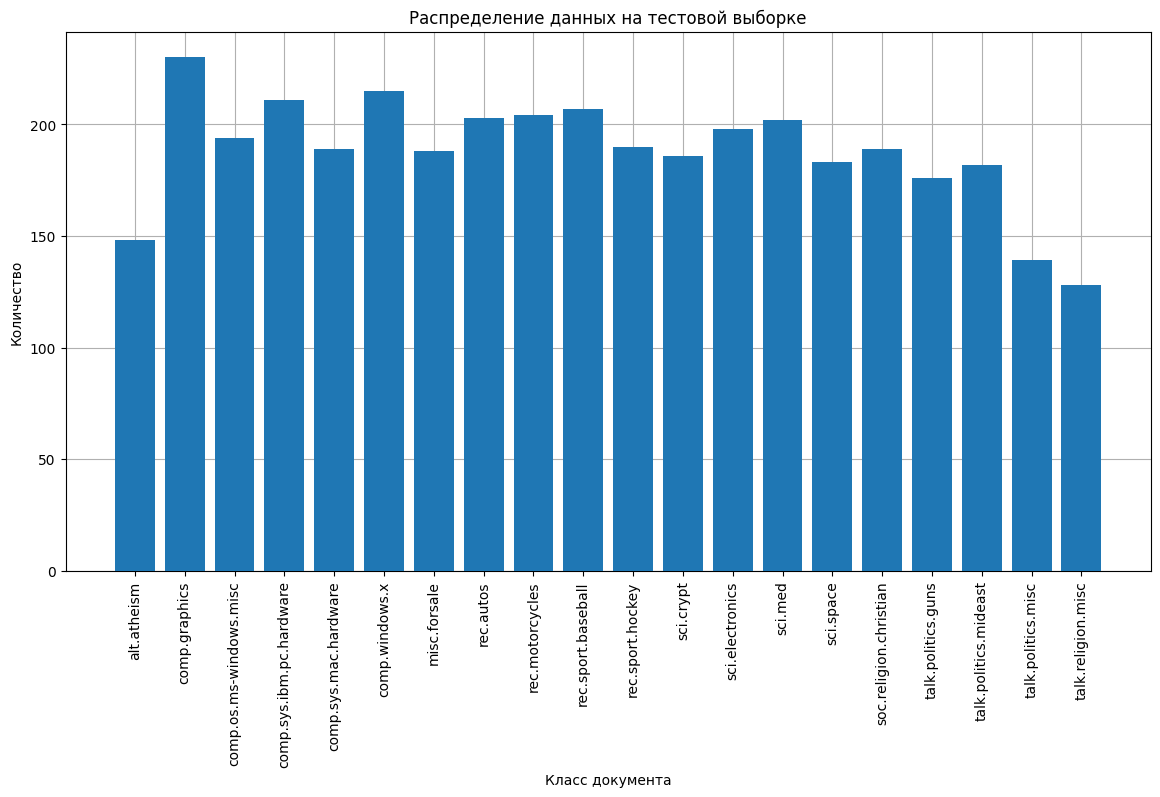

In [20]:
showDistribution(test, "Распределение данных на тестовой выборке")

## **Бейзлайн - SVC над tf-idf**

### **tf-idf эмбеддинг**

In [21]:
# Объединение листа слов wordds в одну строку
# для последующей обработки tf-idf sklearn
# нужна при исользовании спеллчекера
def list2str(words: list[str]) -> str:
    return " ".join(words)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Применение tfidf (минимальное кол-во вхождений токена - 3)
vectorizer = TfidfVectorizer(stop_words="english", min_df=3)
trainVecX = vectorizer.fit_transform(train["Text"])
testVecX = vectorizer.transform(test["Text"])

### **Обучение SVC**

In [23]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


# Подсчет и показ метрик (accuracy, recall, f1)
# pred - вывод модели
# trueLabels - реальные значения
def metrics(pred: np.array, trueLabels: np.array) -> None:

    # Подсчет метрик
    accuracy = accuracy_score(trueLabels, pred)
    recall = recall_score(trueLabels, pred, average='macro')
    f1 = f1_score(trueLabels, pred, average='macro')

    print(f"Accuracy:\t{accuracy * 100:.3f}%")
    print(f"Recall:\t\t{recall * 100:.3f}%")
    print(f"F1:\t\t{f1 * 100:.3f}%")

    # Построение матрицы ошибок
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(trueLabels, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказание')
    plt.ylabel('Действительный класс')
    plt.show()

Accuracy:	89.155%
Recall:		88.896%
F1:		89.089%


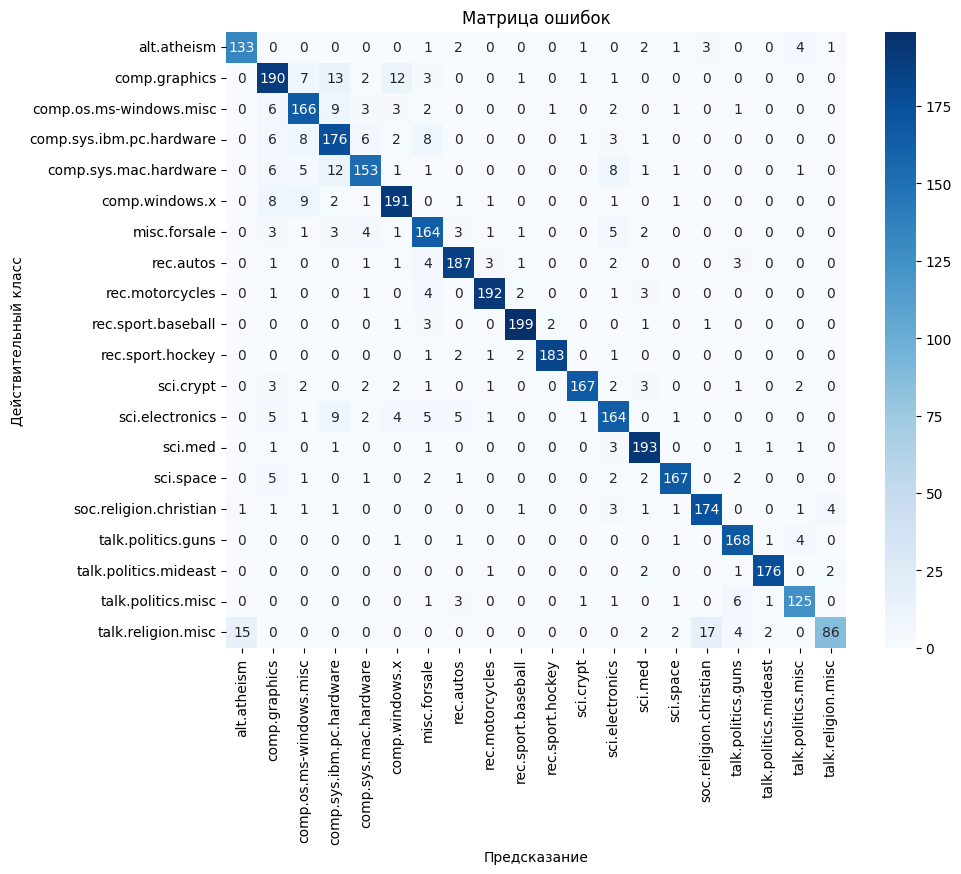

In [24]:
from sklearn.svm import SVC


# Обучение SVC на tf-idf эмбеддингах
model = SVC(kernel="linear")
model.fit(trainVecX, train["Target"])

pred = model.predict(testVecX)
metrics(pred, test["Target"])

## **Большая модель - Fine-tuning Distil BERT**

**Рассмотр длин тектов**

In [25]:
# Возвращает длину текста
def getLength(text: str) -> int:
    return len(text.split())


# Получение длинн текстов
lengths = data["Text"].apply(getLength)

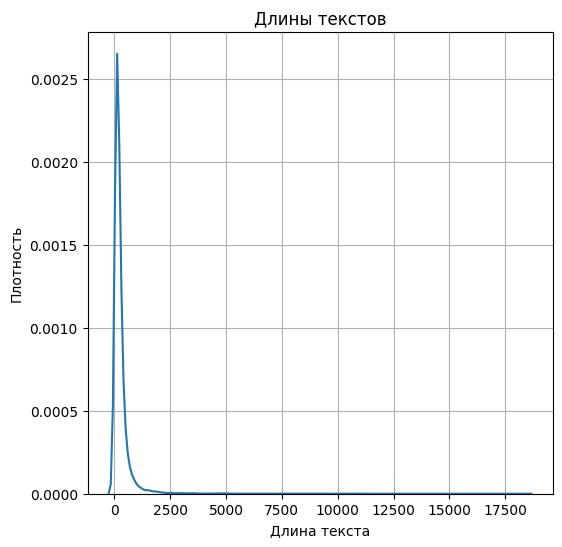

In [26]:
plt.figure(figsize=(6, 6))
plt.grid()
sns.kdeplot(lengths)
plt.title('Длины текстов')
plt.xlabel('Длина текста')
plt.ylabel('Плотность')
plt.show()

In [27]:
print(f"Медиана длины: {lengths.median()}")

Медиана длины: 170.0


**Ограничение длины ввода BERT 512 слов. В связи с этим необходимо проверить возвожно ли использовать модель без модификаций.**

In [28]:
percentage = np.sum(lengths < 512) / len(lengths) * 100

print(f"Процент текстов длиной меньших 512 слов {percentage:.3f}%")

Процент текстов длиной меньших 512 слов 89.330%


**Модель сможет принять полностью большинство поданного текcта из датасета.** 

### **Обучение Distil BERT**

In [29]:
from transformers import AutoTokenizer

import torch
from torch.utils.data import Dataset, DataLoader


# Надстройка над датасетом + токенизация
class news20Dataset(Dataset):

    # df - pandas DataFrame с данными
    # tokenizer - токенизатор предобученной Distil BERT модели
    def __init__(self, df: pd.DataFrame, tokenizer: Callable):
        self.df = df
        self.tokenizer = tokenizer

    # Кол-во данных/текстов датасете
    def __len__(self) -> int:
        return self.df["Text"].size

    # Запрос одного элемента
    # idx - номер элемента
    def __getitem__(self, idx: int) -> dict:
        text = self.df["Text"].iloc[idx]
        label = torch.tensor(self.df["Target"].iloc[idx])

        # Токенизация
        tokenizedText = self.tokenizer(text,
                                       truncation=True,
                                       padding='max_length',
                                       max_length=512)

        # Id токенов
        inputIds = torch.tensor(tokenizedText['input_ids'])
        # Маска для скрытия последующих элементов
        attentionMask = torch.tensor(tokenizedText['attention_mask'])

        data_dict = {"input_ids": inputIds,
                     "attention_mask": attentionMask,
                     "label": label}

        return data_dict

/home/mainuser/anaconda3/envs/textEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
# Формирование датасетов и лоадеров для разбиения на батчи

tokenizerBert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

trainDataset = news20Dataset(train, tokenizerBert)
testDataset = news20Dataset(test, tokenizerBert)

trainLoader = DataLoader(
    trainDataset,
    batch_size=10,
    shuffle=True,
    num_workers=6
)

testLoader = DataLoader(
    testDataset,
    batch_size=10,
    shuffle=True,
    num_workers=6
)

In [53]:
from transformers import AutoModelForSequenceClassification


# Загрузка Distil BERT
pretrained_distilbert = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=CLS_COUNT)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# Отключить апдейт весов для парметров модели
for param in pretrained_distilbert.parameters():
    param.requires_grad = False

# Включить апдейт весов для классификатора
for param in pretrained_distilbert.pre_classifier.parameters():
    param.requires_grad = True

for param in pretrained_distilbert.classifier.parameters():
    param.requires_grad = True

In [60]:
import pytorch_lightning as pl
import torchmetrics


# Обучаю при помощи надстройки над Pytorch - Pytorch lightning
class LightningBERT(pl.LightningModule):

    # model - пердобученная BERT модель
    def __init__(self, model, learning_rate=5e-6):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        # Фиксироуется функция потерь
        self.lossFn = torch.nn.CrossEntropyLoss()

    # Вывод при данным:
    # input_ids - id токенов
    # attention_mask - маска для ввода
    # Вывод - словарь "сырой" вывод под ключем "logits"
    def forward(self, input_ids, attention_mask, labels=None) -> dict:
        out = self.model(input_ids,
                         attention_mask=attention_mask,
                         labels=labels)
        return out

    # Шаг обучения
    # batch - данные в текущеем батче
    # batch_idx - индекс батча
    #
    # Возвращает loss (backprop выполняется тренером pytorch lightning)
    def training_step(self, batch, batch_idx) -> float:

        # Предсказание
        outputs = self.forward(input_ids=batch["input_ids"],
                               attention_mask=batch["attention_mask"])

        # Получение "сырого" вывода
        logits = outputs["logits"]
        # Получение таргета/класса документов для элементов из батча
        labels = batch["label"]

        # Получение лосса/потери
        loss = self.lossFn(logits, labels)

        return loss

    # Конфигурация оптимзатора - выбран Adam
    # learning rate передаетсся из констректора
    #
    # Возвращает оптимизатор
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.learning_rate)
        return optimizer

In [69]:
# Инициализация модели, тренера и начало обучения

lightningBERT = LightningBERT(pretrained_distilbert)

# Модель сохраняется теренером в директории lightning_logs 
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    devices=1,
    enable_progress_bar=True
)

trainer.fit(model=lightningBERT,
            train_dataloaders=trainLoader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                                | Params | Mode 
-----------------------------------------------------------------------
0 | model  | DistilBertForSequenceClassification | 67.0 M | eval 
1 | lossFn | CrossEntropyLoss                    | 0      | train
-----------------------------------------------------------------------
605 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.875   Total estimated model params size (MB)
1         Modules in train mode
96        Modules in eval mode


Epoch 19: 100%|███████████████████████████████████████████████████████████| 1505/1505 [03:44<00:00,  6.70it/s, v_num=40]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|███████████████████████████████████████████████████████████| 1505/1505 [03:46<00:00,  6.65it/s, v_num=40]


5:59: W291 trailing whitespace


In [70]:
from tqdm import tqdm

# Получить результаты предсказания как numpy массивы
# необходимо для последующего подсчета метрик
def getTestResults(model, testLoader):
    model.eval()
    with torch.no_grad():
        # инициализация пустых масссиовов для конкатинации
        preds = np.empty(0)
        labels = np.empty(0)
        for input_dict in tqdm(testLoader):
            input_ids = input_dict['input_ids']
            attention_mask = input_dict['attention_mask']
            label = input_dict['label']

            # Получение предсказаний
            out = model(input_ids,
                        attention_mask=attention_mask)
            pred = torch.argmax(out.logits, 1)

            # Конкатенация с предидущими предсказаниями и реальными значениями классов
            labels = np.concatenate((labels, label.numpy()))
            preds = np.concatenate((preds, pred.numpy()))

        return preds, labels

5:1: E302 expected 2 blank lines, found 1
21:80: E501 line too long (86 > 79 characters)


In [74]:
preds, labels = getTestResults(lightningBERT, testLoader)

100%|█████████████████████████████████████████████████████████████████████████████████| 377/377 [21:16<00:00,  3.38s/it]


Accuracy:	74.402%
Recall:		73.630%
F1:		73.465%


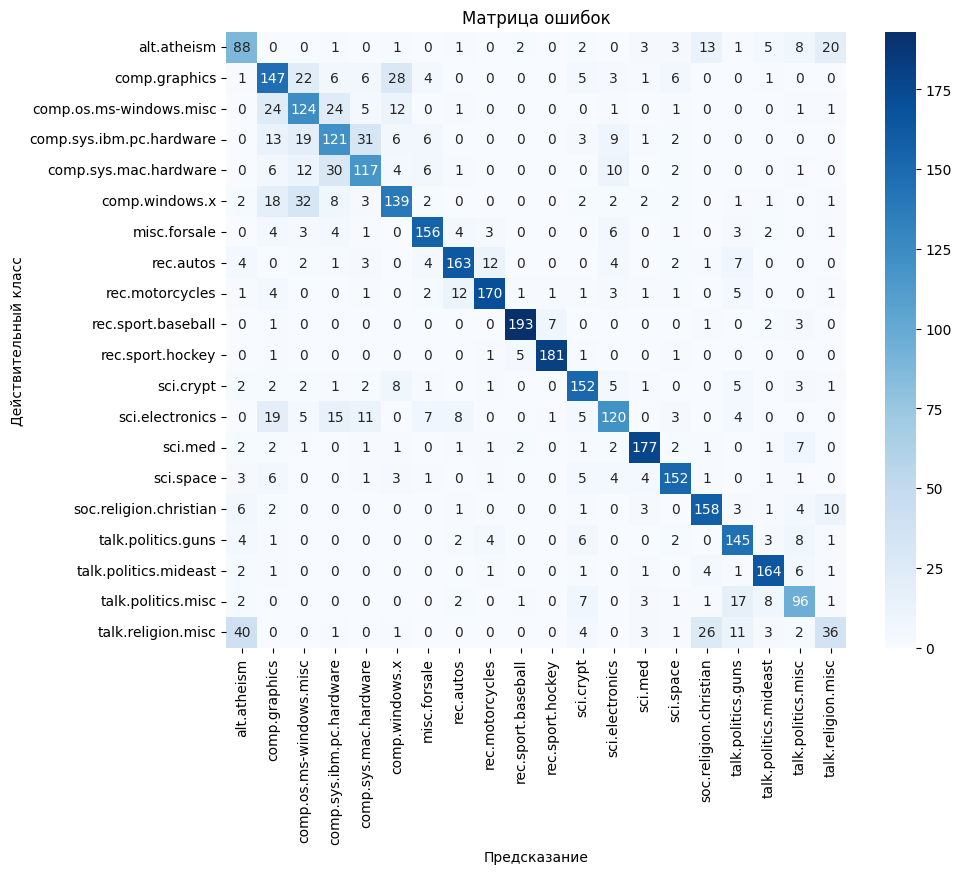

In [75]:
metrics(preds, labels)

**Сохранение SVC модели**

In [83]:
import pickle

with open('SVC/vec.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('SVC/svc.pickle', 'wb') as f:
    pickle.dump(model, f)